# Load packages

In [8]:
import numpy as np
import torch
import sys, os, inspect
cur_dir= os.path.abspath(os.path.dirname(inspect.getfile(inspect.currentframe())))
sys.path.append(cur_dir+"/../methods/Mix")
sys.path.append("/../methods/Mix")
sys.path.append(sys.path[0]+"/../methods/Mix")
from utils import *
from MMD_M import *
from matplotlib import pyplot as plt
import os
import pyroc
import pandas as pd
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

In [9]:
dataset = np.load('../datasets/HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5170877, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5829122, 28)
dataset_P = MatConvert(dataset_P, device, dtype)
dataset_Q = MatConvert(dataset_Q, device, dtype)

In [10]:
features = ['lepton pT', 
            'lepton eta', 
            'lepton phi', 
            'missing energy magnitude', 
            'missing energy phi', 
            'jet 1 pt', 
            'jet 1 eta', 
            'jet 1 phi', 
            'jet 1 b-tag', 
            'jet 2 pt', 
            'jet 2 eta', 
            'jet 2 phi', 
            'jet 2 b-tag', 
            'jet 3 pt', 
            'jet 3 eta', 
            'jet 3 phi', 
            'jet 3 b-tag', 
            'jet 4 pt', 
            'jet 4 eta',
            'jet 4 phi', 
            'jet 4 b-tag', 
            'm_jj',   # 22
            'm_jjj',  # 23
            'm_lv',   # 24
            'm_jlv',  # 25
            'm_bb',   # 25
            'm_wbb',  # 26
            'm_wwbb'] # 27
# 2 decimal print
# feture_mean = np.round(np.mean(dataset, axis=0), 2)
# print('mean: ', feture_mean)


# Use MMD method to plot 
modify n_train and path_LFI to change the checkpoint.

In [11]:
# Load the trained model
n_train = 1300000
path_LFI = '../methods/Mix/checkpoints/n_tr=1300000#0/'
model = DN().to(device)
another_model = another_DN().to(device)
try:
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path_LFI)
except:
    print('No model found...')
    print('Please first run Res_Net/MMD_M.py to train the model and make sure that path_LFI is a valid checkpoint')
    raise Exception('No model found. Please first run ./Res_Net/MMD_M.py to train the model and make sure that path_LFI is a valid checkpoint')

In [12]:
# Set up $X^{test}$ and $Y^{test}$ to compute score function and threshold
n_test = 10000
X_test = dataset_P[np.random.choice(n_train, n_test, replace=False)]
Y_test = dataset_Q[np.random.choice(n_train, n_test, replace=False)]
thres, sig_to_sig, back_to_back = get_thres_at_once(X_test, Y_test, X_test, Y_test,
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, 
                    batch_size = 10000)

thres, sig_to_sig, back_to_back

(0.19032063, 0.2881, 0.9848)

In [13]:
# Compute distribuion of score
n_eval = 1000000
X_eval = dataset_P[n_train+n_test : n_train+n_test+n_eval]
Y_eval = dataset_Q[n_train+n_test : n_train+n_test+n_eval]
XY_eval = torch.concatenate((X_eval, Y_eval), axis=0)
phi_Z = torch.zeros(2*n_eval, dtype=dtype, device=device)
batch_size = 10000
for i in range(n_eval//batch_size):
    phi_Z[i*batch_size:(i+1)*batch_size] = compute_score_func(XY_eval[i*batch_size:(i+1)*batch_size], X_test, Y_test, 
                                                            model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst)
idx = phi_Z > thres

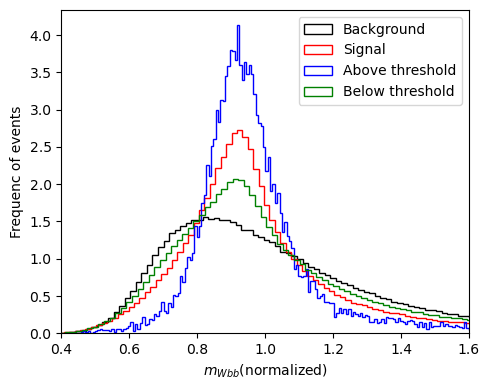

In [14]:
# Plot
feature = 26
Background = X_eval[:, feature].cpu().numpy()
Signal = Y_eval[:, feature].cpu().numpy()
Conditioned_to_signal = XY_eval[idx, feature].cpu().numpy()
Conditioned_to_background = XY_eval[~idx, feature].cpu().numpy()
bins = 500
alpha = 1
plt.figure(figsize=(5, 4), dpi=100)
plt.hist(Background, bins=bins, alpha=alpha, label='Background', density=True, color='black', histtype='step')
plt.hist(Signal, bins=bins, alpha=alpha, label='Signal', density=True, color='red', histtype='step')
plt.hist(Conditioned_to_signal, bins=bins, alpha=alpha, label='Above threshold', density=True, color='blue', histtype='step')
plt.hist(Conditioned_to_background, bins=bins, alpha=alpha, label='Below threshold', density=True, color='green', histtype='step')
plt.xlabel('$m_{Wbb}$(normalized)')
plt.ylabel('Frequenc of events')
plt.xlim(0.4, 1.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig('../assets/m_wbb.pdf', dpi=300)